### Import libraries

In [2]:
#!pip install einops
#!pip install cohere
#!pip install accelerate
#!pip install bitsandbytes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, GenerationConfig, TextStreamer, LlamaForCausalLM, LlamaTokenizer

import torch
from inspect import cleandoc
import cohere
import time

### Functions definition

In [ ]:
def find_most_common_element(couples):
    # Flatten all couples into a single list
    all_elements = [element for pair in couples for element in pair]

    # Count occurrences of each element
    element_counts = Counter(all_elements)

    # Find the most common element
    most_common_element, max_count = element_counts.most_common(1)[0]

    return most_common_element, max_count

def remove_pairs_with_element(pair_array, element_to_remove):
    # Use a list comprehension to filter out pairs that contain the element to be removed
    new_pairs = [pair for pair in pair_array if element_to_remove not in pair]

    return new_pairs

def remove_element_from_pairs(indices,to_remove):
    for pair in indices:
        to_remove.append(pair[0])
    indices.clear()

# DAIGT-V2 reading

In [3]:
#lettura dataset originale + aggiunta id
df = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
df['id'] = range(0, len(df))
df

,text,label,prompt_name,source,RDizzl3_seven,id
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,0
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,1
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,2
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,3
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,4
...,...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44863
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44864
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44865
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44866


# Dataset analysis

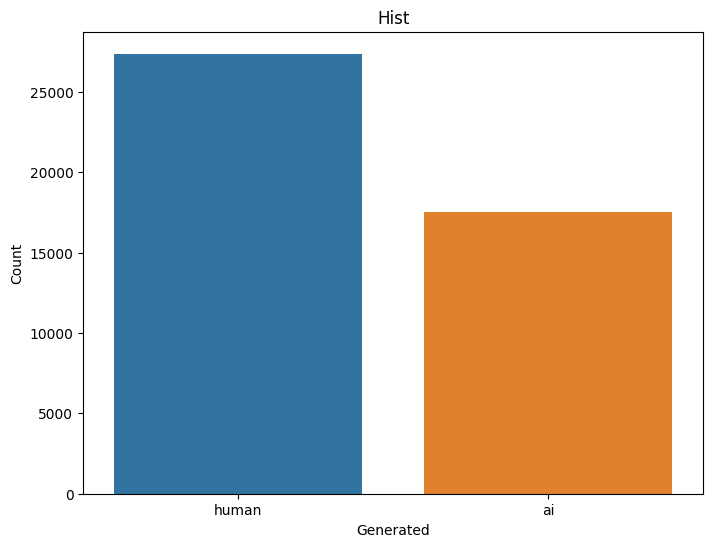

label
0    27371
1    17497
Name: count, dtype: int64


In [5]:
# conteggio label dataset
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index.map({0: 'human', 1: 'ai'}), y=label_counts.values)
plt.title('Hist')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.show()

print(label_counts)

In [6]:
# per ogni prompt contiamo le label
prompt_count = df.groupby(['prompt_name', 'label']).size().unstack()
prompt_count

prompt_df = pd.DataFrame(columns=['prompt_name', 'human', 'ai'])
grouped_df = df.groupby('prompt_name')['label'].value_counts().unstack().reset_index()

# Assegnare i risultati al nuovo DataFrame
prompt_df['prompt_name'] = grouped_df['prompt_name']
prompt_df['human'] = grouped_df[0]
prompt_df['ai'] = grouped_df[1]

prompt_df

,prompt_name,human,ai
0,"""A Cowboy Who Rode the Waves""",1372,524
1,Car-free cities,2666,2051
2,Cell phones at school,1656,463
3,Community service,1542,550
4,Distance learning,2157,3397
5,Does the electoral college work?,2714,1720
6,Driverless cars,1886,364
7,Exploring Venus,1862,314
8,Facial action coding system,2167,917
9,Grades for extracurricular activities,1626,490


# To skip - Start

In [ ]:
ids_to_remove = []

#prompt_similarity = ['Car-free cities','Does the electoral college work?','Phones and driving']

for prompt in prompt_df['prompt_name'].unique():
    # Filter the dataframe based on label and prompt_name
    filtered_df = df.loc[(df['label'] == 0) & (df['prompt_name'] == prompt), ['text', 'id']]

    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(filtered_df['text'])

    # Calculate cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Create a DataFrame with cosine similarity values
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, columns=filtered_df['id'], index=filtered_df['id'])

    # Set a threshold
    threshold = 0.9

    # Find indices of pairs with similarity greater than the threshold
    indices = [(filtered_df.index[i], filtered_df.index[j]) for i in range(len(cosine_sim_df))
               for j in range(i + 1, len(cosine_sim_df.columns))
               if cosine_sim_df.iloc[i, j] > threshold]
    
    while len(indices)>0:
        to_delete, count = find_most_common_element(indices)
        if count > 1:
            indices = remove_pairs_with_element(indices,to_delete)
            ids_to_remove.append(to_delete)
        else:
            remove_element_from_pairs(indices,ids_to_remove)

In [ ]:
# remove human text with high similarity
df = df[~df['id'].isin(ids_to_remove)]

In [ ]:
df.to_csv('/kaggle/working/daigt-v2_nosimilarity.csv', index=False)

# To skip - End

In [7]:
df = pd.read_csv('/kaggle/input/no-similarity/daigt-v2_nosimilarity.csv')

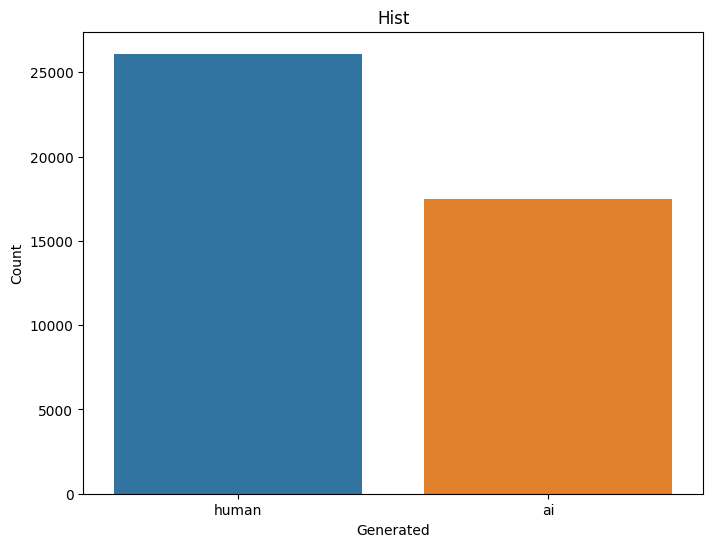

label
0    26105
1    17497
Name: count, dtype: int64


In [10]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index.map({0: 'human', 1: 'ai'}), y=label_counts.values)
plt.title('Hist')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.show()

print(label_counts)

In [11]:
prompt_count = df.groupby(['prompt_name', 'label']).size().unstack()
prompt_count

prompt_df = pd.DataFrame(columns=['prompt_name', 'human', 'ai'])
grouped_df = df.groupby('prompt_name')['label'].value_counts().unstack().reset_index()

prompt_df['prompt_name'] = grouped_df['prompt_name']
prompt_df['human'] = grouped_df[0]
prompt_df['ai'] = grouped_df[1]

prompt_df

,prompt_name,human,ai
0,"""A Cowboy Who Rode the Waves""",1372,524
1,Car-free cities,2006,2051
2,Cell phones at school,1656,463
3,Community service,1542,550
4,Distance learning,2157,3397
5,Does the electoral college work?,2125,1720
6,Driverless cars,1886,364
7,Exploring Venus,1862,314
8,Facial action coding system,2167,917
9,Grades for extracurricular activities,1626,490


# Generate new text to decrease the unbalance between prompts under the threshold

In [14]:
threshold = 500

# Seleziona le righe che soddisfano la condizione
to_generate = prompt_df[prompt_df['ai'] + threshold < prompt_df['human']].copy()

# Calcola la differenza e assegna utilizzando .loc[]
to_generate.loc[:, 'difference'] = to_generate['human'] - to_generate['ai']

to_generate

,prompt_name,human,ai,difference
0,"""A Cowboy Who Rode the Waves""",1372,524,848
2,Cell phones at school,1656,463,1193
3,Community service,1542,550,992
6,Driverless cars,1886,364,1522
7,Exploring Venus,1862,314,1548
8,Facial action coding system,2167,917,1250
9,Grades for extracurricular activities,1626,490,1136
11,Phones and driving,1151,415,736
13,Summer projects,1750,951,799
14,The Face on Mars,1583,310,1273


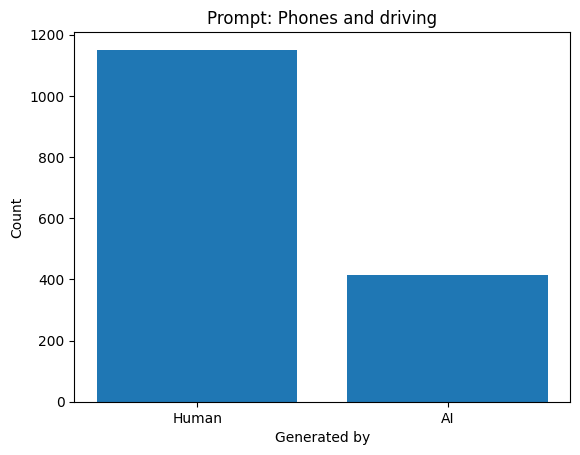

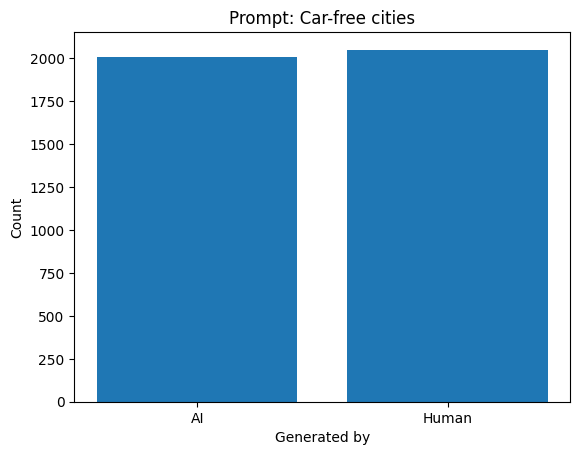

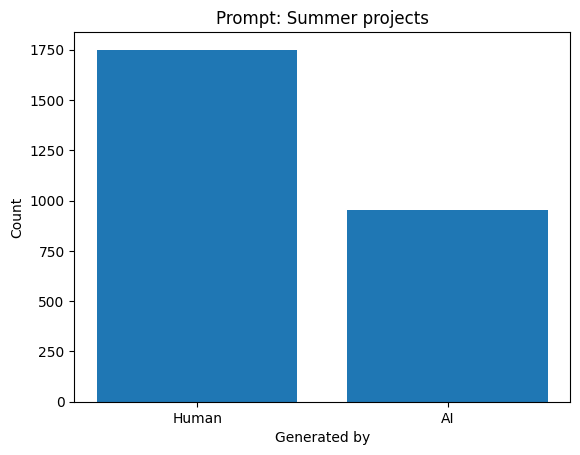

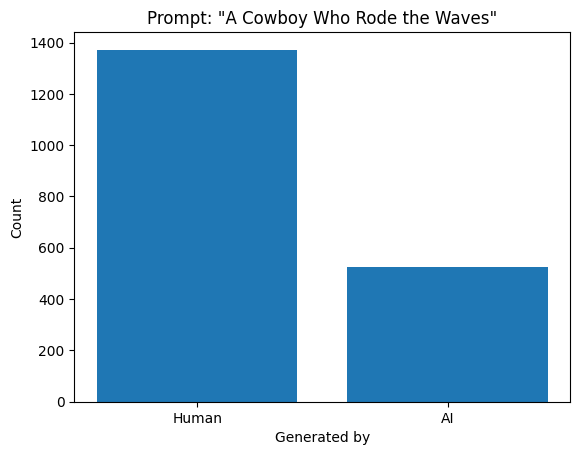

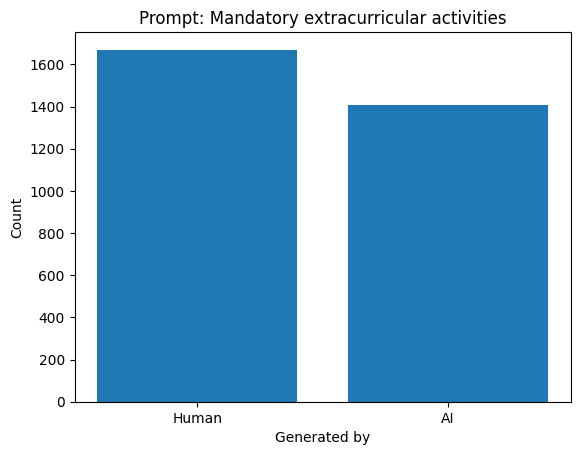

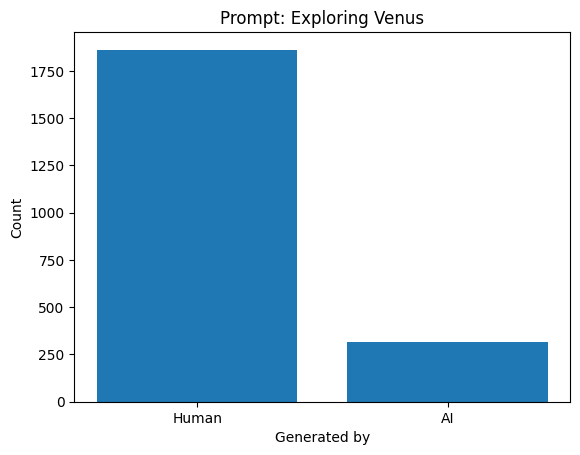

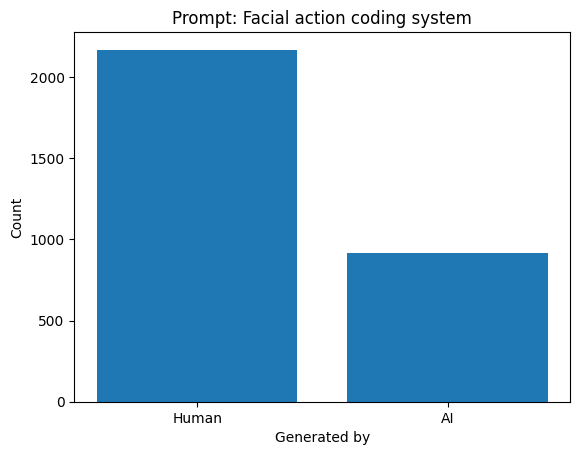

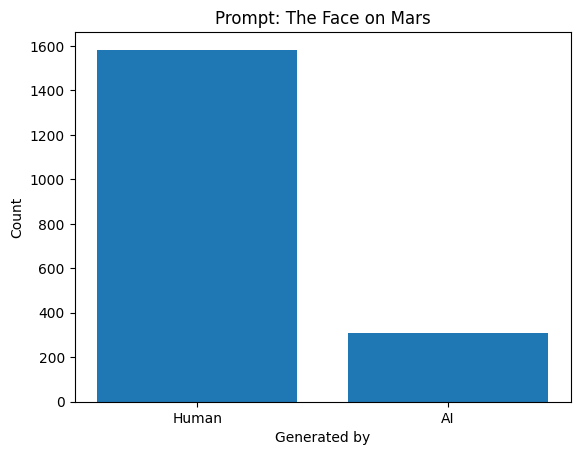

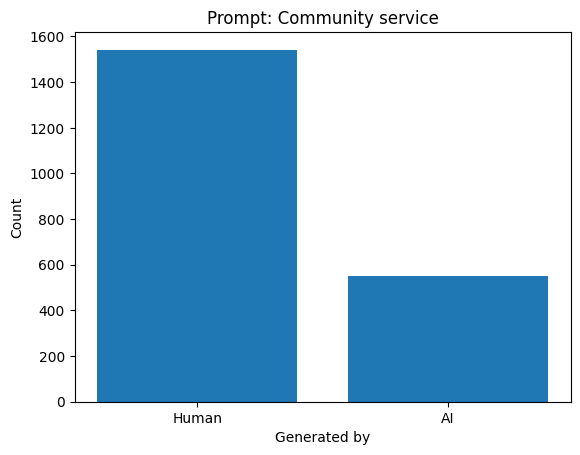

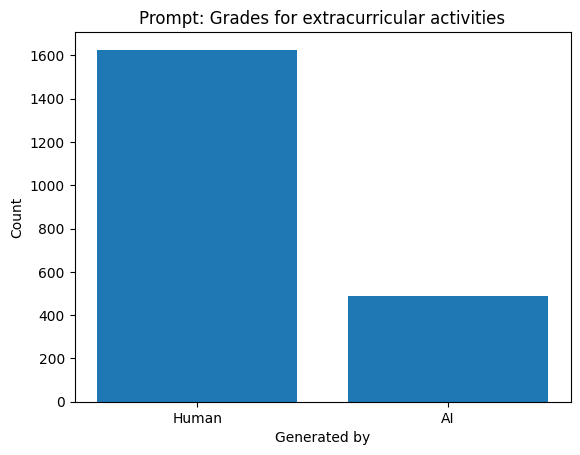

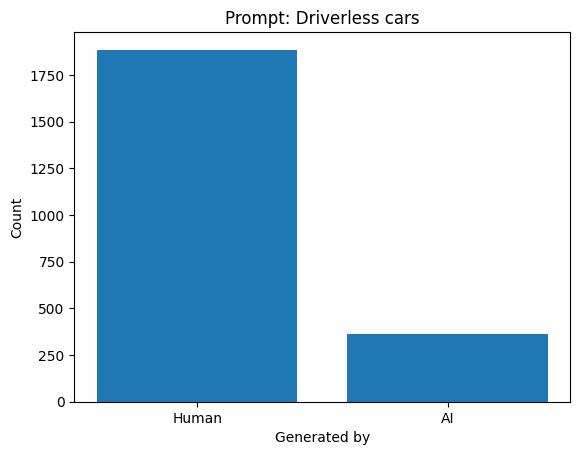

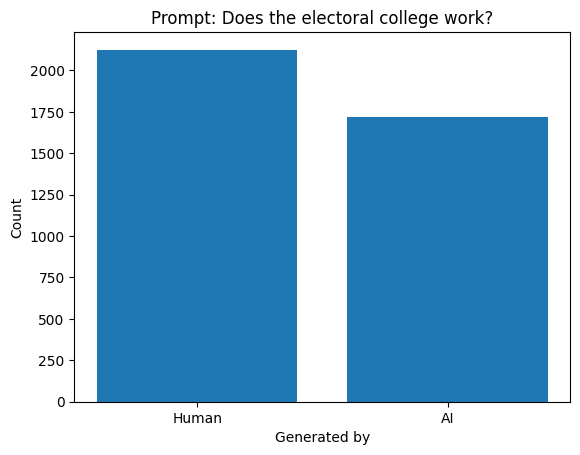

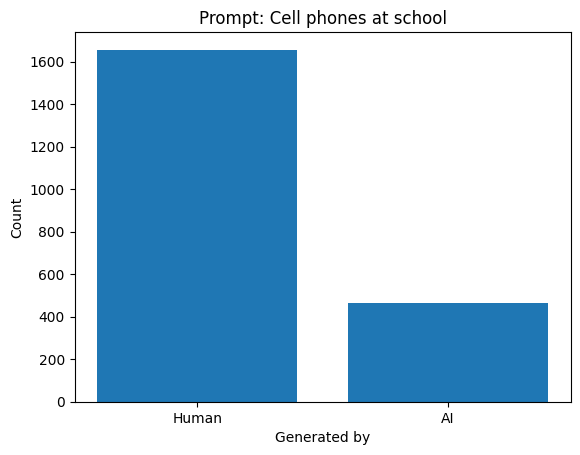

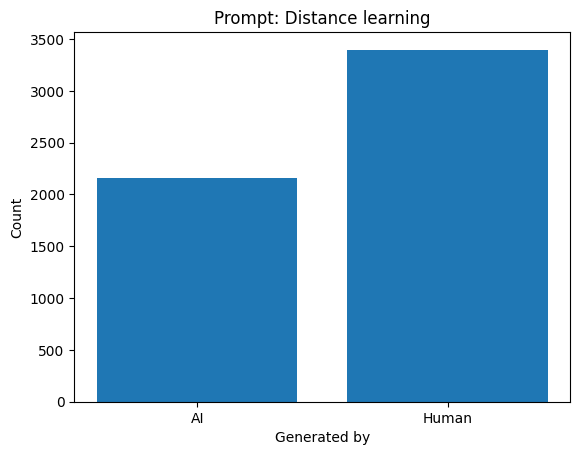

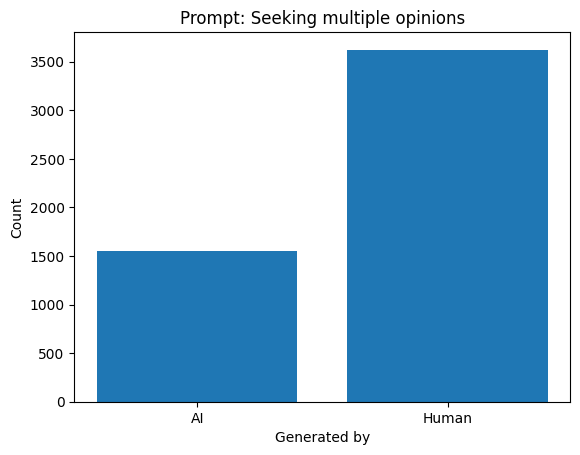

In [16]:
for prompt in df['prompt_name'].unique():
    prompt_data = df[df['prompt_name'] == prompt]
    counts = prompt_data['label'].value_counts()

    # Creazione dell'istogramma
    plt.bar(counts.index, counts.values, tick_label=['Human', 'AI'])
    plt.title(f'Prompt: {prompt}')
    plt.xlabel('Generated by')
    plt.ylabel('Count')
    plt.show()

In [ ]:
class CohereGenerator:
    def __init__(self):
        self.apiKey = "PLACEHOLDER"
        self.co = cohere.Client(f'{self.apiKey}')
    def generate_text(self, item_to_generate: int, prompt: str):
        responses = []
        for _ in range(item_to_generate):
            response = self.co.generate(
              model='command-light',
              prompt=f'''You are a student working on the following assignment: write a text that talks about {prompt}.
                            Use natural expressions similar to humans.
                            Vary sentence structure to avoid monotony.
                            Include relevant personal details about the topic.
                            Use metaphors and analogies to explain concepts.
                            Respect the appropriate tone and formality.
                            Consider the audience and adapt the writing style.
                            Avoid direct or implicit references to AI identity.
                            Correct grammatical and stylistic errors.
                            Try to be not repetitive.
                            Ensure logical connections between ideas.
                            Use empathetic and sensitive language when needed.''',
              max_tokens=1024,
              temperature=0.8,
              presence_penalty=0.2)
            responses.append(response.generations[0].text)
            time.sleep(15)
        return responses

In [ ]:
class MistralGenerator:
    def __init__(self):
        self.model_name = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"
        self.bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
        )
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                load_in_4bit=True,
                quantization_config=self.bnb_config,
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True,
            )
    def generate_essay(self, prompt: str):
        messages = [{
            "role":"user",
            "content": prompt
        }]
        model_inputs = self.tokenizer.apply_chat_template(messages, return_tensors = "pt").to('cuda')
        generated_ids = self.model.generate(
            model_inputs,
            max_new_tokens = 7500,
            do_sample = True,
            pad_token_id = self.tokenizer.eos_token_id
        )     
        decoded = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        text = decoded[0].split("[/INST]")[1]
        return text
        
    def generate_text(self, item_to_generate: int, prompt: str):
        texts=[]
        for _ in range(item_to_generate):
            prompt_combined = f'''You are a student working on the following assignment: write a text that talks about {prompt}
                            Instructions: 
                            Use natural expressions similar to humans.
                            Vary sentence structure to avoid monotony.
                            Include relevant personal details about the topic.
                            Use metaphors and analogies to explain concepts.
                            Respect the appropriate tone and formality.
                            Consider the audience and adapt the writing style.
                            Avoid direct or implicit references to AI identity.
                            Correct grammatical and stylistic errors.
                            Try to be not repetitive.
                            Ensure logical connections between ideas.
                            Use empathetic and sensitive language when needed.'''
            texts.append(self.generate_essay(prompt_combined).strip())
        return texts

### Important: This code is designed ideally. During experimentation, we split the generation process into multiple parts and executed them on different machines. This is necessary because we have limited GPU resources on Kaggle.

In [ ]:
cohereGenerator = CohereGenerator()

In [ ]:
for index, row in to_generate.iterrows():
    if(row['difference']> 1000):
        prompt_name=row['prompt_name']
        itemsForGenerator = row['difference']//4
        texts = cohereGenerator.generate_text(itemsForGenerator, prompt_name)
        data = {'text': texts,
            'label': [1] * len(texts),
            'prompt_name': [prompt_name] * len(texts),
            'source': ['cohere'] * len(texts)}
        cohere_df = pd.DataFrame(data)
        cohere_df.to_csv(f'/kaggle/working/cohere_{prompt_name}.csv', index=False)
        df = pd.concat([df,cohere_df], ignore_index=True)

In [ ]:
mistralGenerator = MistralGenerator()

In [ ]:
for index, row in to_generate.iterrows():
    if(row['difference']> 1000):
        prompt_name=row['prompt_name']
        itemsForGenerator = row['difference']//4
        texts = mistralGenerator.generate_text(itemsForGenerator, prompt_name)
        data = {'text': texts,
            'label': [1] * len(texts),
            'prompt_name': [prompt_name] * len(texts),
            'source': ['mistral'] * len(texts)}
        mistral_df = pd.DataFrame(data)
        mistral_df.to_csv(f'/kaggle/working/mistral_{prompt_name}.csv', index=False)
        df = pd.concat([df,mistral_df], ignore_index=True)

# DAIGT-V3 creation

In [ ]:
df.to_csv('/kaggle/working/daigt-v3.csv', index=False)